In [1]:
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit.providers.fake_provider import FakeVigo

In [2]:
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
print(bit_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [6]:



q = QuantumRegister(3,'q')
c = ClassicalRegister(1, 'c')
circuit = QuantumCircuit(q,c)

circuit.cx(q[0],q[1])
circuit.cx(q[0],q[2])
circuit.measure_all()

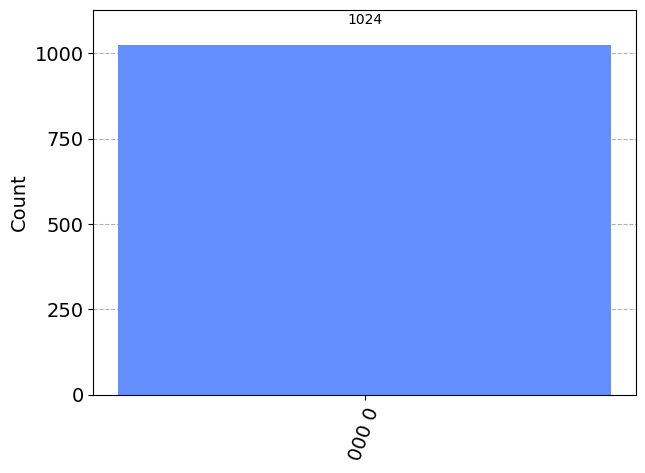

In [7]:
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circuit).result()
plot_histogram(result_ideal.get_counts(0))

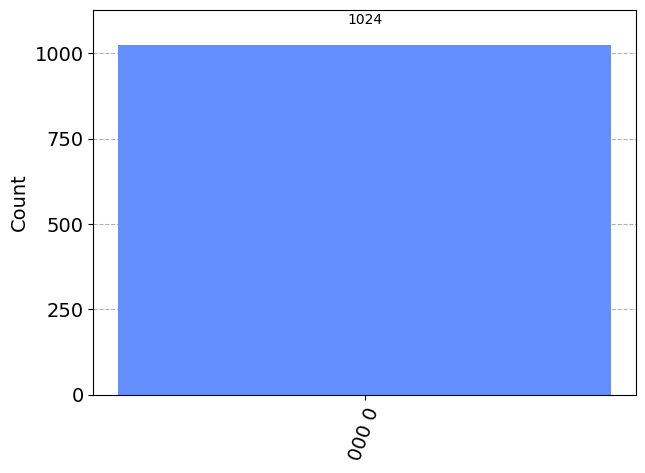

In [12]:
# Create an empty noise model
bit_flip_model = NoiseModel()
bit_flip_model.add_all_qubit_quantum_error(bit_flip, "reset")
sim_noise = AerSimulator(noise_model=bit_flip_model)


# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circuit, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)